In [1]:
%matplotlib inline


# Comparing different hierarchical linkage methods on toy datasets

This example shows characteristics of different linkage
methods for hierarchical clustering on datasets that are
"interesting" but still in 2D.

The main observations to make are:

- single linkage is fast, and can perform well on
  non-globular data, but it performs poorly in the
  presence of noise.
- average and complete linkage perform well on
  cleanly separated globular clusters, but have mixed
  results otherwise.
- Ward is the most effective method for noisy data.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


In [2]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

Generate datasets. We choose the size big enough to see the scalability
of the algorithms, but not too big to avoid too long running times



In [3]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

Run the clustering and plot



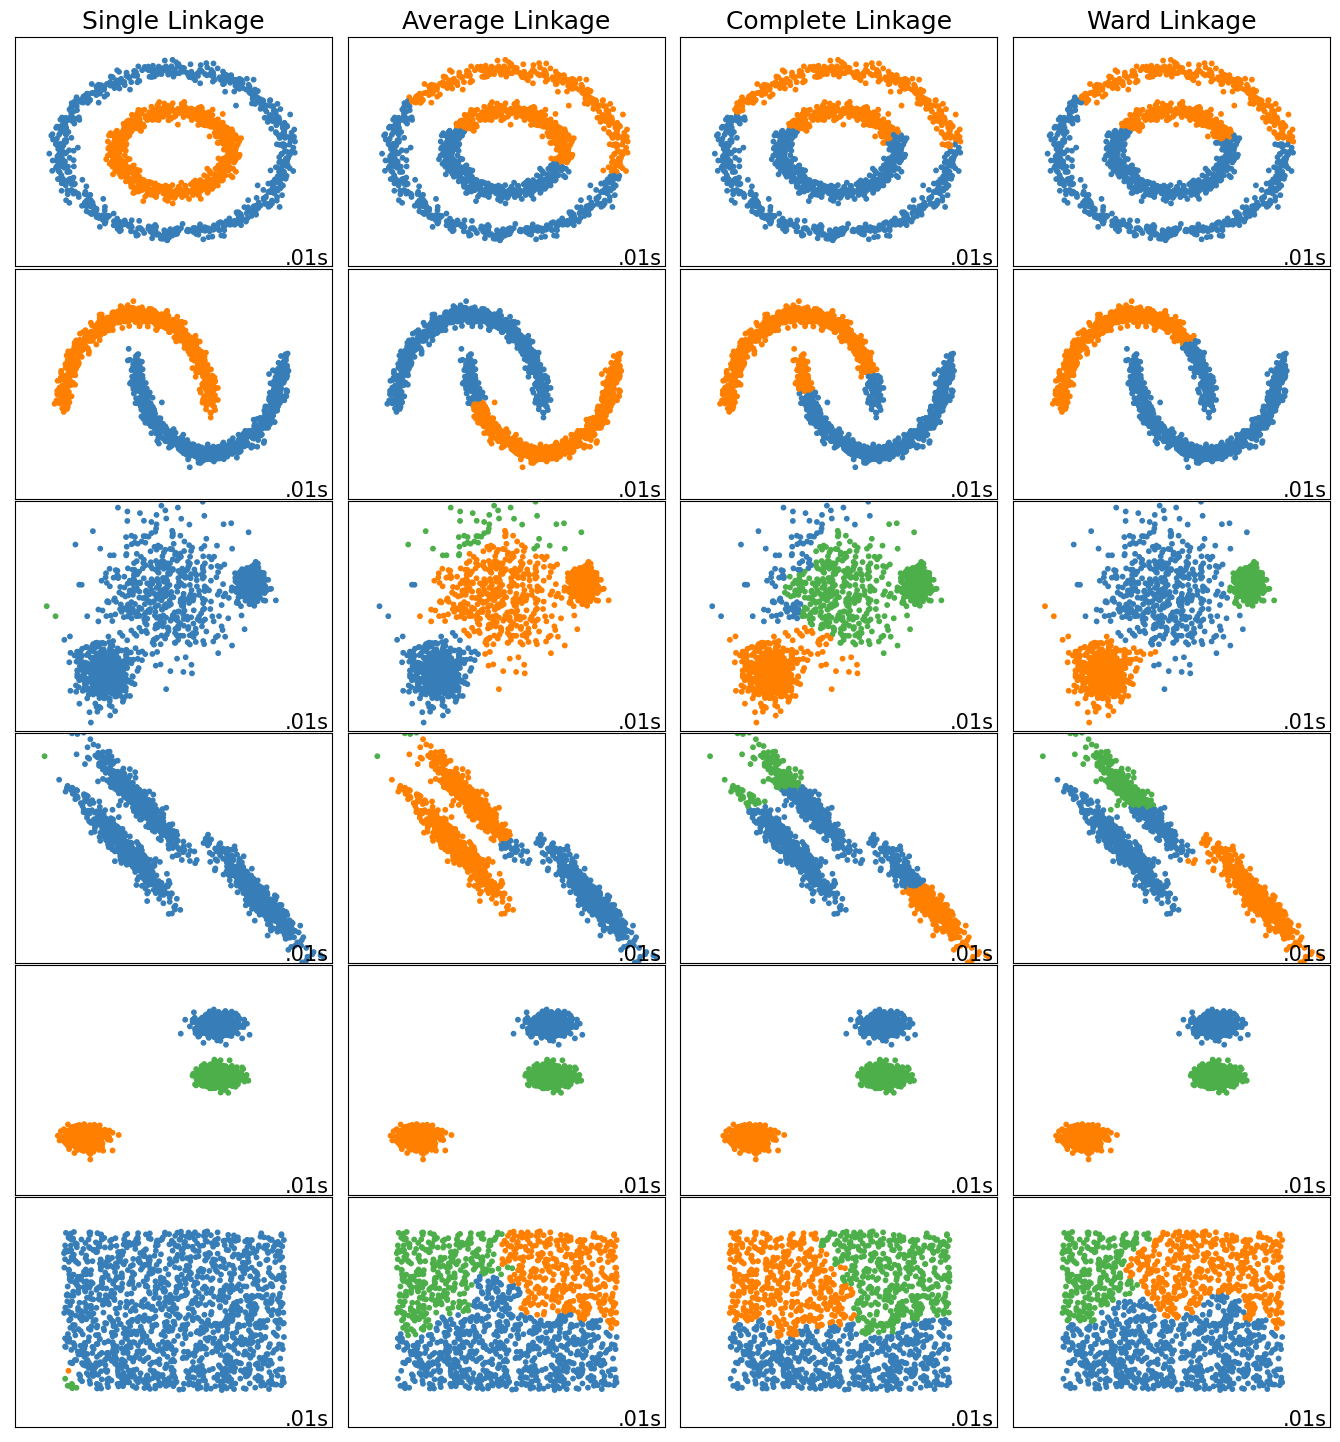

In [4]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward"
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="complete"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="average"
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="single"
    )

    clustering_algorithms = (
        ("Single Linkage", single),
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## R2 Values

In [5]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [6]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

sns.set()

In [7]:

noisy_circles

noisy_circles_df = pd.DataFrame(noisy_circles[0])
noisy_circles_df

,0,1
0,-0.677999,-0.698757
1,0.931437,0.191391
2,0.548291,-0.006017
3,0.872837,0.375023
4,0.435427,-0.294726
...,...,...
1495,0.473205,0.034184
1496,0.406588,0.274089
1497,-0.345188,-0.358048
1498,0.017197,-0.945138


In [8]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10

sns.set(style="white")

def plot_linkage_r2(df, hc_methods=hc_methods, max_nclus=max_nclus, title="R2 Plot"):
    r2_hc_methods = np.vstack(
        [
            get_r2_hc(df=df, link_method=link, max_nclus=max_nclus) 
            for link in hc_methods
        ]
    ).T
    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    # Plot data
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4, ax=ax2)
    
    
    # Finalize the plot
    plt.suptitle(title, fontsize=21)
    ax2.legend(title="HC methods", title_fontsize=11)
    ax2.set_xticks(range(1, max_nclus + 1))
    ax2.set_xlabel("Number of clusters", fontsize=13)
    ax2.set_ylabel("R2 metric", fontsize=13)
    
    
    ax1.scatter(df.iloc[:,0],df.iloc[:,1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    

    plt.show()

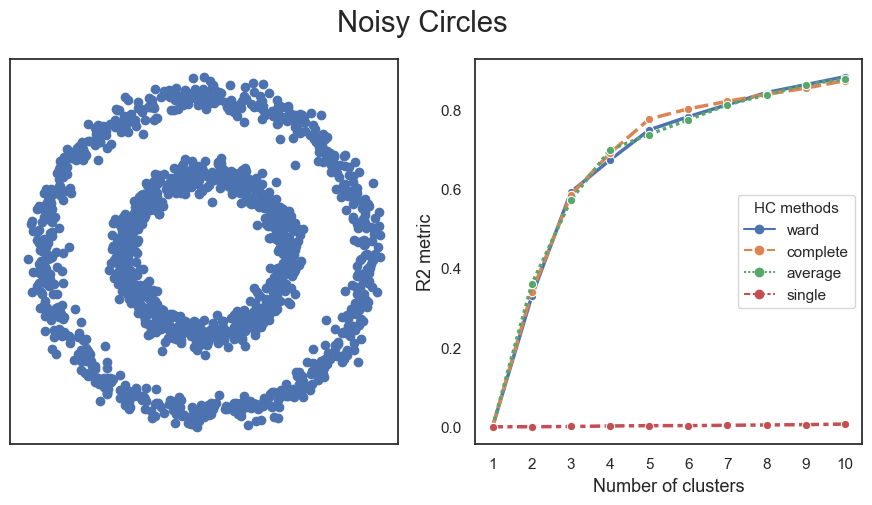

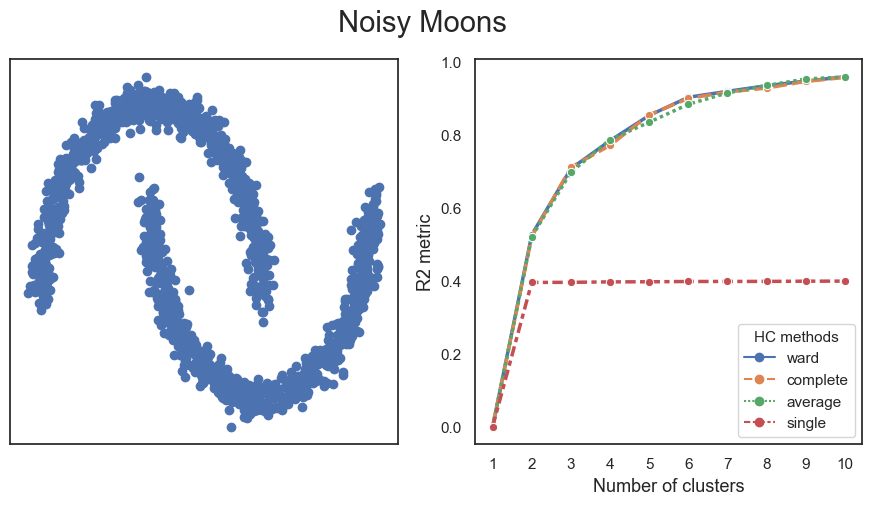

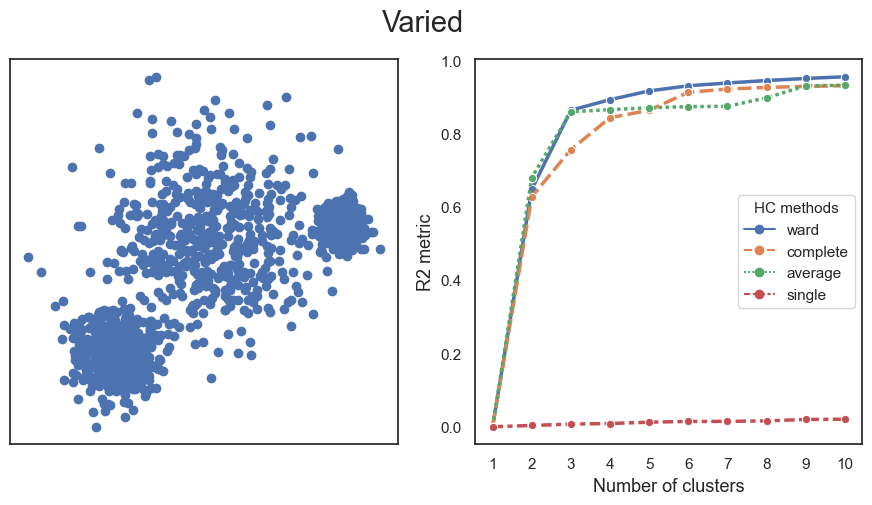

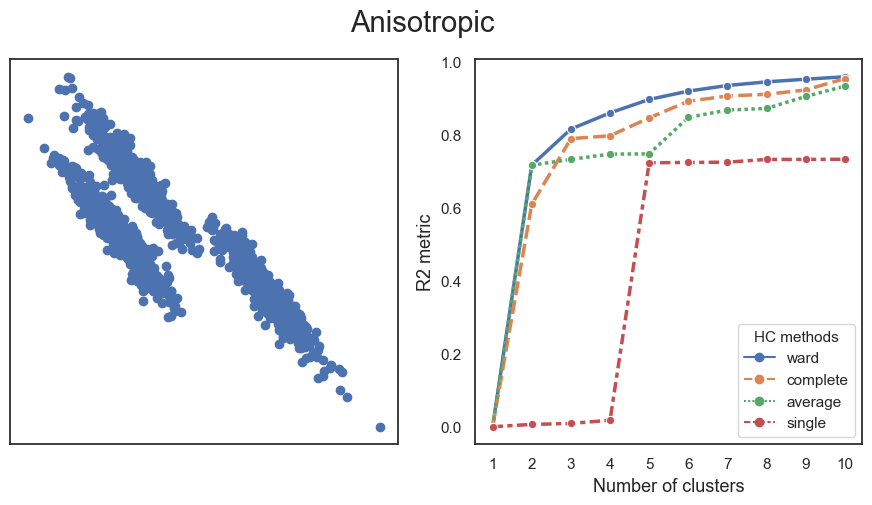

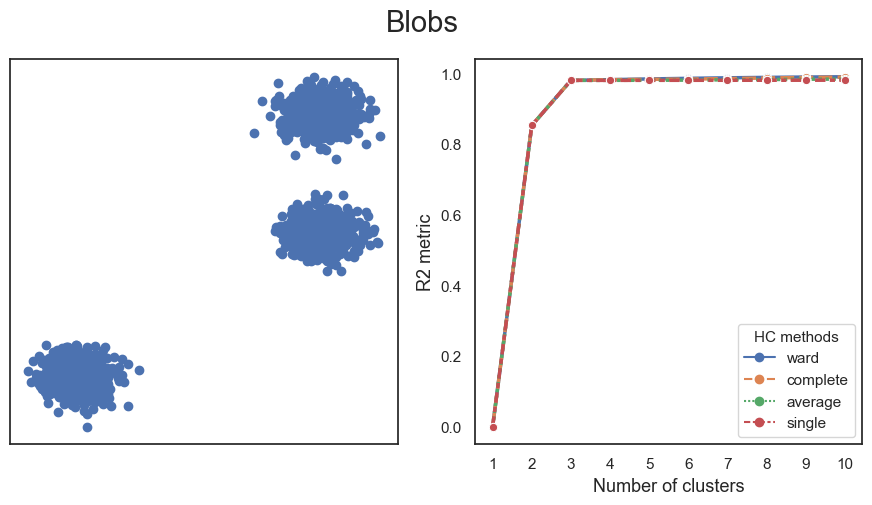

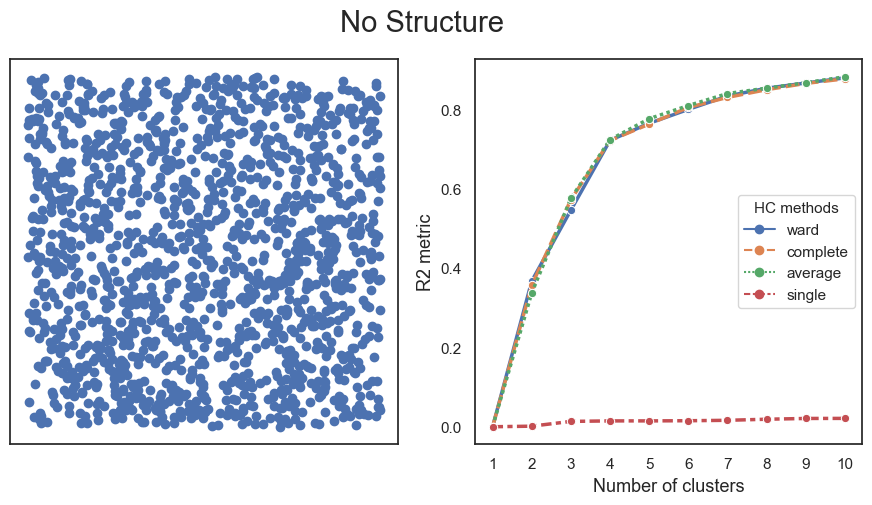

In [9]:
hc_data = [
    (noisy_circles, "Noisy Circles"),
    (noisy_moons, "Noisy Moons"),
    (varied, "Varied"),
    (aniso, "Anisotropic"),
    (blobs, "Blobs"),
    (no_structure, "No Structure"),
]

for h in hc_data:
    plot_linkage_r2(df=pd.DataFrame(h[0][0]), title=h[1])